<a href="https://colab.research.google.com/github/swethak00/SwethaKanakamedala_INFO5731_Spring2021/blob/main/In_class_exercise_07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The seventh in-class-exercise (20 points in total, 10/21/2020)**

Question description: In the last in-class-exercise (exercise-06), you collected the titles of 100 articles about data science, natural language processing, and machine learning. The 100 article titles will be used as the text corpus of this exercise. Perform the following tasks:

# **Downloading and Installing required modules**

**Installing nltk and stopwords**

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

**Installing java**

In [ ]:
import os
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
  !java -version
install_java()

openjdk version "11.0.8" 2020-07-14
OpenJDK Runtime Environment (build 11.0.8+10-post-Ubuntu-0ubuntu118.04.1)
OpenJDK 64-Bit Server VM (build 11.0.8+10-post-Ubuntu-0ubuntu118.04.1, mixed mode, sharing)


**Upgrading Gensim**

In [ ]:
!pip install --upgrade gensim

Requirement already up-to-date: gensim in /usr/local/lib/python3.6/dist-packages (3.8.3)


**Downloading en module in spicy**

In [ ]:
import spacy.cli
spacy.cli.download("en")

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


## (1) (8 points) Generate K topics by using LDA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here: 

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

**Importing Required Modules**

In [ ]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

**Importing Stopwords module from nltk**

In [ ]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

**Reading Google Articles from csv to df**

In [ ]:
google_articles_titles = pd.read_csv('/content/nlp_google_scholar_articles.csv', encoding = "ISO-8859-1")
google_articles_titles.head(10)

,Titles
0,Comparative Study of CNN and RNN for Natural L...
1,Class Diagram Extraction from Textual Requirem...
2,Deep Learning in Natural Language Processing
3,Natural Language Processing and Semantical Rep...
4,HuggingFace's Transformers: State-of-the-art N...
5,Applying natural language processing (NLP) bas...
6,Jumping NLP Curves: A Review of Natural Langua...
7,Method and apparatus for process control by us...
8,Facilitating cancer research using natural lan...
9,Natural language processing: an introduction


**Dataframe to list**

In [ ]:
data = google_articles_titles['Titles'].tolist()

**Tokenization and punctuation**

In [ ]:
data_words = []
for line in data:
  data_words.append(gensim.utils.simple_preprocess(str(line), deacc=True))

**Building Bigrams and Trigrams models**

In [ ]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


**Removing Stopwords and getting Bigrams**

In [ ]:
after_stopword_removal = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in data_words]
bigrams = [bigram_mod[doc] for doc in after_stopword_removal]

**Lemmatization**

In [ ]:
nlp = spacy.load('en', disable=['parser', 'ner'])
allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']
after_lemmatization = []
for sent in bigrams:
  doc = nlp(" ".join(sent)) 
  after_lemmatization.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])

**Building Dictionary, Corpus and Term Document Frequency**

In [ ]:
id2word = corpora.Dictionary(after_lemmatization)
texts = after_lemmatization
corpus = [id2word.doc2bow(text) for text in after_lemmatization]
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1)]]


In [ ]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('language', 1), ('natural', 1), ('processing', 1)]]

**Building LDA Model with 20 topics**

In [ ]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

**Compute Model Perplexity and Coherence Score**

In [ ]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus)) 
coherence_model_lda = CoherenceModel(model=lda_model, texts=after_lemmatization, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -5.3233222892584156

Coherence Score:  0.5252976742847884


**Setting environment Path and giving Mallet Path**

In [ ]:
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet'

**Building LDA Mallet Model**

In [ ]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:252: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


**Compute Coherence Value for LDA**

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=after_lemmatization, start=2, limit=60, step=6)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:252: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


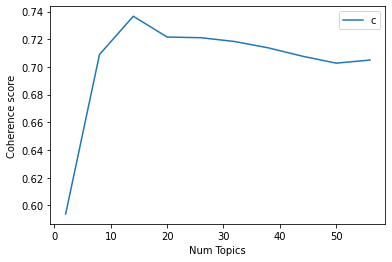

In [ ]:
limit=60; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
for no_of_topics, cv in zip(range(2, 60, 6), coherence_values):
  print("Num Topics:", no_of_topics, " - Coherence Value:", round(cv, 4))

Num Topics: 2  - Coherence Value: 0.5938
Num Topics: 8  - Coherence Value: 0.709
Num Topics: 14  - Coherence Value: 0.7367
Num Topics: 20  - Coherence Value: 0.7216
Num Topics: 26  - Coherence Value: 0.7211
Num Topics: 32  - Coherence Value: 0.7184
Num Topics: 38  - Coherence Value: 0.7138
Num Topics: 44  - Coherence Value: 0.7078
Num Topics: 50  - Coherence Value: 0.7028
Num Topics: 56  - Coherence Value: 0.705


In [ ]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=14, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

**Printing Topics**

In [ ]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.071*"natural" + 0.071*"processing" + 0.071*"language" + 0.025*"use" + '
  '0.025*"extract" + 0.025*"exist" + 0.025*"medical" + 0.025*"plagiarism" + '
  '0.025*"evaluation" + 0.025*"problem"'),
 (1,
  '0.133*"language" + 0.121*"natural" + 0.109*"processing" + '
  '0.037*"statistical" + 0.013*"biomedicine" + 0.013*"architecture" + '
  '0.013*"computer" + 0.013*"unified" + 0.013*"significance" + 0.013*"assist"'),
 (2,
  '0.117*"natural" + 0.117*"language" + 0.096*"processing" + 0.032*"use" + '
  '0.022*"text" + 0.022*"medical" + 0.022*"system" + 0.022*"process" + '
  '0.011*"information" + 0.011*"method"'),
 (3,
  '0.132*"natural" + 0.132*"processing" + 0.132*"language" + 0.076*"retrieval" '
  '+ 0.076*"information" + 0.039*"toolkit" + 0.020*"build" + 0.020*"customize" '
  '+ 0.020*"linguistic" + 0.020*"efficiently"'),
 (4,
  '0.068*"natural" + 0.068*"language" + 0.035*"issue" + 0.035*"engineering" + '
  '0.035*"current" + 0.035*"tool" + 0.035*"uml" + 0.035*"generate" + '
  '0.0

**Topic Visualization**

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
12    -0.079359 -0.094244       1        1  19.763981
7     -0.139875  0.014646       2        1  19.030780
2     -0.072799 -0.017332       3        1  11.146665
6     -0.083941 -0.031549       4        1  11.072735
1     -0.077492  0.017788       5        1   9.613659
5     -0.041845  0.124536       6        1   7.495433
3     -0.068610  0.000320       7        1   5.395464
11    -0.016923  0.065027       8        1   5.290640
0      0.016258 -0.062803       9        1   4.193556
8      0.006909  0.001350      10        1   2.587881
4      0.057663 -0.020597      11        1   2.361545
10     0.181853  0.005126      12        1   1.137734
9      0.158983 -0.001091      13        1   0.456555
13     0.159177 -0.001178      14        1   0.453372, topic_info=           Term       Freq      Total Category  logprob  loglift
1       natural  78.000000  78.000000  Default  30.0000  30.0000
0      language  81.000000  81.000000  Default  29.0000  29.0000
61  information   5.000000   5.000000  Default  28.0000  28.0000
2    processing  76.000000  76.000000  Default  27.0000  27.0000
62    retrieval   3.000000   3.000000  Default  26.0000  26.0000
..          ...        ...        ...      ...      ...      ...
64      cluster   0.013425   1.408820  Topic14  -5.4424   0.7428
63      chinese   0.013425   1.408845  Topic14  -5.4424   0.7428
62    retrieval   0.013425   3.391742  Topic14  -5.4424  -0.1358
61  information   0.013425   5.493238  Topic14  -5.4424  -0.6180
60        topic   0.013425   1.408473  Topic14  -5.4424   0.7430

[684 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
211       3  0.699025  abstract
16        4  0.700392   acquire
186       3  0.468755    active
186       8  0.468755    active
190       3  0.699025   advance
...     ...       ...       ...
161       2  0.317912       web
161       4  0.317912       web
68        5  0.709800   whisper
168       4  0.700392      word
176       3  0.699025      year

[344 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[13, 8, 3, 7, 2, 6, 4, 12, 1, 9, 5, 11, 10, 14])

# Summarization of LDA Topics



1. Using NLP to extract solution for Medical Plagarism
2. Computer unified assistance for statistical biomedicine architecture
3. Processing medical information using NLP
4. Retrieving information efficiently using customized linguistics
5. Generating current engineering software models using NLP
6. NLP for text mining in helath and medicine industry
7. Base for Art labelling platform technique using NLP
8. NLP for extracting and Reviewing application techniques
9. NLP for machine based syntactic feature recognition
10. NLP toolkit for sentiment and opinion review analysis
11. Extarcting information from radiology infant pnuemonia
12. Retrieving defetcts of surveys
13. Evaluating challenges of clinical records
14. Extracting reviews from clinical systems


## (2) (8 points) Generate K topics by using LSA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here:

https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python

**Importing LSA model**

In [ ]:
from gensim.models import LsiModel

**Bulding Model**

In [ ]:
lsamodel = LsiModel(corpus, 20, id2word)

**Computing coherence value for LSA**

In [ ]:
def compute_coherence_values_lsi(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=20, id2word = dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

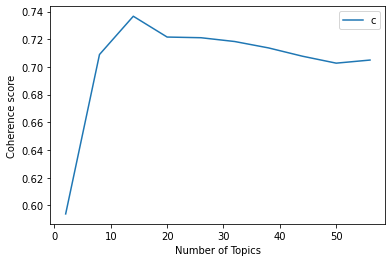

In [ ]:
start,stop,step=2,60,6
model_list_lsa, coherence_values_lsa = compute_coherence_values_lsi(id2word, corpus,after_lemmatization,stop, start, step)
x = range(start, stop, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
for no_of_topics, cv in zip(range(2, 60, 6), coherence_values_lsa):
  print("Num Topics:", no_of_topics, " - Coherence Value:", round(cv, 4))

Num Topics: 2  - Coherence Value: 0.4425
Num Topics: 8  - Coherence Value: 0.4255
Num Topics: 14  - Coherence Value: 0.4335
Num Topics: 20  - Coherence Value: 0.4505
Num Topics: 26  - Coherence Value: 0.4255
Num Topics: 32  - Coherence Value: 0.4335
Num Topics: 38  - Coherence Value: 0.4255
Num Topics: 44  - Coherence Value: 0.4505
Num Topics: 50  - Coherence Value: 0.4335
Num Topics: 56  - Coherence Value: 0.4335


**Printing Topics**

In [ ]:
pprint(lsamodel.print_topics())

[(0,
  '0.584*"language" + 0.558*"natural" + 0.550*"processing" + 0.098*"use" + '
  '0.057*"system" + 0.054*"base" + 0.043*"clinical" + 0.042*"nlp" + '
  '0.041*"review" + 0.041*"information"'),
 (1,
  '-0.764*"use" + 0.192*"base" + -0.177*"technique" + -0.176*"extract" + '
  '-0.162*"nlp" + -0.150*"report" + -0.145*"detection" + -0.122*"process" + '
  '0.121*"clinical" + 0.113*"language"'),
 (2,
  '0.398*"extract" + 0.335*"medical" + -0.289*"base" + 0.272*"electronic" + '
  '0.267*"clinical" + 0.189*"record" + 0.182*"information" + 0.162*"datum" + '
  '0.152*"result" + 0.152*"prostate"'),
 (3,
  '-0.575*"system" + -0.395*"review" + -0.204*"systematic" + 0.158*"base" + '
  '-0.152*"opinion" + -0.145*"information" + 0.135*"text" + -0.135*"mining" + '
  '-0.123*"unstructured" + -0.119*"nlp"'),
 (4,
  '0.447*"base" + 0.247*"text" + 0.214*"health" + 0.198*"system" + '
  '0.194*"medical" + 0.192*"nlp" + 0.156*"extract" + 0.155*"electronic" + '
  '0.148*"ideation" + 0.148*"suicidal"'),
 (5,


# Summarization of LSA Topics

1. NLP for clinical review system
2. NLP for clinical report detection
3. Electronic based medical record extraction using NLP
4. Systematic Review of unstructured opinion information using NLP
5. Extraction of medical and suicidal elctronic information
6. NLP for sentimental review
7. NLP for health and sytematic reviews
8. Automatic detection and text processing of clinical information
9. Clinical information extraction using deep learning
10. NLP for semenatical representation of survey text
11. Review of information retrieval using NLP
12. Clinical architecture extraction
13. Summary of detection techniques
14. Software for respiratory detection using deep learning
15. Machine learning solution for active health survey
16. Technique for research process detection
17. Retrieval process for research care and information mining
18. Home automation control and voice detection using IOT
19. Efficient soluiton for chinese cluster and whister graphs using NLP
20. Challenges for home automation control using NLP

## (3) (4 points) Compare the results generated by the two topic modeling algorithms, which one is better? You should explain the reasons in details.

Latent Semantic Analysis has lower accuracy than Latent Dirichlet allocation modelling algorithm. Here, The Coherence value for optimal number of topics for LSA is 45 where as for LDA is 73. From this we can compute that Accuracy for LDA is better than the LSA . LDA has better accuracy that means we can easily generalize LDA model to other new documents. LSA has less interpretability among the topics beacuse of dimensionality reduction where as we can interpret topic very easily in LDA. I got 14 topics for LDA which are highly interpretable than 20 topics of LSA. 